# **'Where's Wally' with Machine Learning: Phase 1 - CNN**

### Imports

In [ ]:
# ==== Standard Libraries ====
import os
import cv2
import math
from PIL import Image
from collections import Counter

# ==== PyTorch & TorchVision ====
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import random_split, DataLoader, WeightedRandomSampler

# ==== Visualisation & Image Processing ====
import numpy as np
import matplotlib.pyplot as plt


from sklearn.metrics import (
    roc_auc_score,
    roc_curve,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)


### Transform data

In [ ]:
dataset_path = 'C:/Users/alici/OneDrive - Swansea University/Dissertation/Hey-Waldo-master/Hey-Waldo-master/128'

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

### Data Augmentation

In [ ]:

wally_path = 'C:/Users/alici/OneDrive - Swansea University/Dissertation/Hey-Waldo-master/Hey-Waldo-master/128/waldo'
augmented_path = 'C:/Users/alici/OneDrive - Swansea University/Dissertation/Hey-Waldo-master/Hey-Waldo-master/128/aug_waldo'

os.makedirs(augmented_path, exist_ok=True)

augment = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(128, scale=(0.8, 1)),
])

for img_name in os.listdir(wally_path):
    img_path = os.path.join(wally_path, img_name)
    image = Image.open(img_path)

    for i in range(5):
        augmented_image = augment(image)
        augmented_image.save(os.path.join(augmented_path, f"aug_{i}_{img_name}"))

print('Augmented images saved.')

Augmented images saved.


In [ ]:
print(f"Total images: {len(dataset)}")
class_counts = Counter([label for _, label in dataset])
for class_idx, count in class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Class '{class_name}': {count} images")

Total images: 1995
Class 'aug_waldo': 565 images
Class 'notwaldo': 1317 images
Class 'waldo': 113 images


### Remap data labels

In [ ]:
current_labels = [label for _, label in dataset.samples]
print("Current unique labels:", set(current_labels))

label_map = {0: 0, 1: 1, 2: 0}
dataset.samples = [(img, label_map[label]) for img, label in dataset.samples]

new_labels = [label for _, label in dataset.samples]
print("Labels after mapping:", set(new_labels))

class_counts = {0: 0, 1: 0}
for _, label in dataset.samples:
    class_counts[label] += 1

print("Class counts after remapping:", class_counts)
dataset.classes = ['wally', 'not wally']

for class_idx, count in class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Class '{class_name}': {count} images")

Current unique labels: {0, 1, 2}
Labels after mapping: {0, 1}
Class counts after remapping: {0: 678, 1: 1317}
Class 'wally': 678 images
Class 'not wally': 1317 images


In [ ]:
print(f"Total images: {len(dataset)}")
class_counts = Counter([label for _, label in dataset])
for class_idx, count in class_counts.items():
    class_name = dataset.classes[class_idx]
    print(f"Class '{class_name}': {count} images")

Total images: 1995
Class 'wally': 678 images
Class 'not wally': 1317 images


### Weighted Random Sample for data

In [ ]:
class_counts = np.bincount([label for _, label in dataset.samples])
total_samples = len(dataset)

class_weights = 1.0 / class_counts
sample_weights = [class_weights[label] for _, label in dataset.samples]

sampler = WeightedRandomSampler(sample_weights, num_samples=total_samples)

dataloader = DataLoader(dataset, batch_size=32, sampler=sampler, num_workers=2)

images, labels = next(iter(dataloader))
print(f"Loaded batch of images: {images.shape}, labels: {labels.shape}")


Loaded batch of images: torch.Size([32, 3, 128, 128]), labels: torch.Size([32])


### Sample augmented image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.25..0.25].


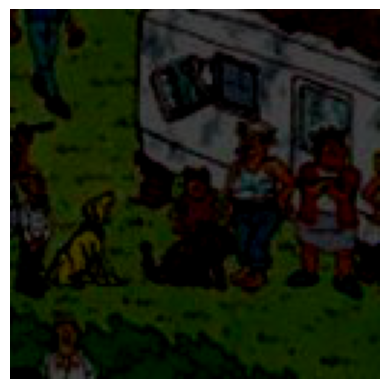

Label: 1


In [ ]:
def display_img(img):
    img = img.numpy().transpose((1, 2, 0))
    img = img * 0.5 * 0.5
    plt.imshow(img)
    plt.axis("off")
    plt.show()

display_img(images[1])
print(f"Label: {labels[1]}")

### Split data and load it in

In [ ]:
train_ratio = 0.7
test_ratio = 0.15
val_ratio = 0.15

train_size = math.floor(train_ratio * total_samples)
val_size = math.floor(val_ratio * total_samples)
test_size = total_samples - train_size - val_size

print(train_size, val_size, test_size)
train_data, val_data, test_data = random_split(dataset, [train_size, val_size, test_size])

print(f"Training samples: {len(train_data)}")
print(f"Validation samples: {len(val_data)}")
print(f"Test samples: {len(test_data)}")

train = DataLoader(train_data, batch_size=32, num_workers=2)
val = DataLoader(val_data, batch_size=32, num_workers=2)
test = DataLoader(test_data, batch_size=32, num_workers=2)

1396 299 300
Training samples: 1396
Validation samples: 299
Test samples: 300


### Reassign correct labels (again) since they since to randomize

In [ ]:
label_map = {
    'notwaldo': 0,
    'aug_waldo': 1,
    'waldo': 1
}

updated_samples = []
for img_path, label in dataset.samples:
    class_name = os.path.basename(os.path.dirname(img_path))
    if class_name in label_map:
        updated_samples.append((img_path, label_map[class_name]))

dataset.samples = updated_samples

new_counts = Counter([label for _, label in dataset.samples])
print("Class counts after remapping:", new_counts)

Class counts after remapping: Counter({0: 1317, 1: 678})


### Batch image sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


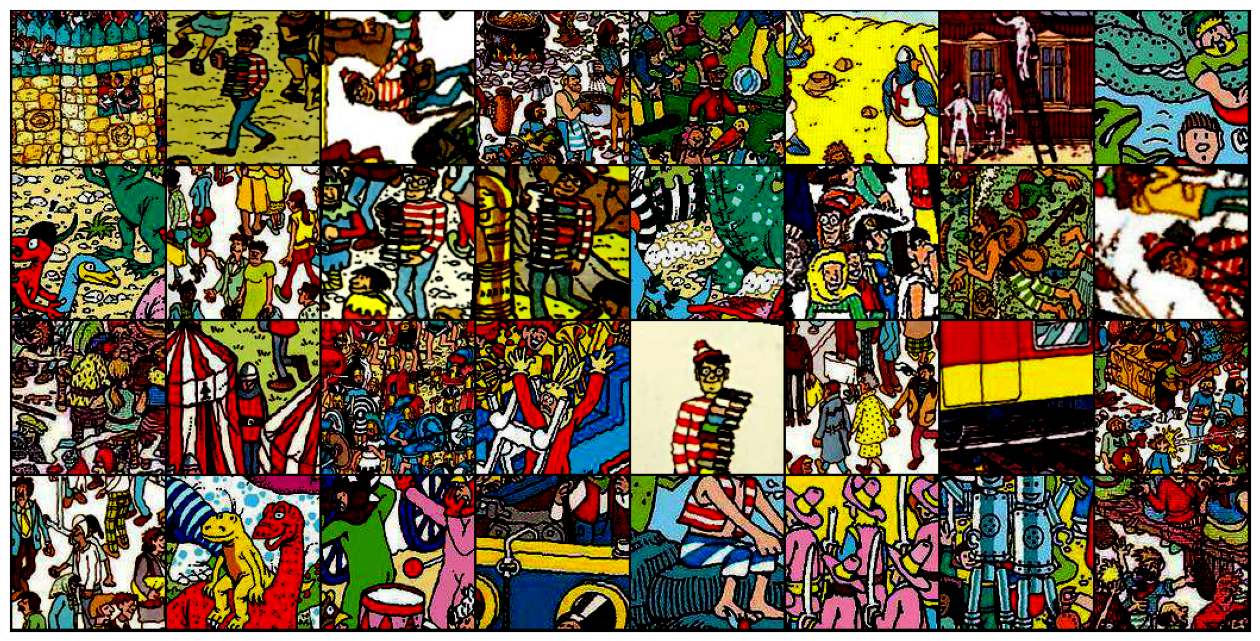

In [ ]:
def show_batch(all):
    for images, labels in all:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break

show_batch(val)

### Custom CNN model

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Dropout(0.25),
            nn.Flatten(),
            nn.Linear(128 * 16 * 16, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.network(x)
        x = x.reshape(x.shape[0], -1)
        return x

model = SimpleCNN()

### Implement optimiser

In [ ]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
print(model)

SimpleCNN(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Dropout(p=0.25, inplace=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=32768, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, out_features=2, bias=True)
  )
)


### Custom training and evaluation

In [ ]:
def train_and_eval(model, train, val, criterion, optimiser, num_epochs):

    train_loss = []
    train_acc = []
    val_loss = []
    val_acc = []

    for epoch in range(num_epochs):

        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train:

            # for param in model.parameters():
            #     print(param.requires_grad)

            optimiser.zero_grad()  # Reset gradients
            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation
            optimiser.step()  # Update weights

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss/len(train)
        epoch_acc = 100 * correct / total

        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val:

                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss

                val_running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_epoch_loss = val_running_loss/len(val)
        val_epoch_acc = 100 * val_correct / val_total

        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"Training: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")
        print(f"Validation: Loss: {val_epoch_loss:.4f}, Accuracy: {val_epoch_acc:.2f}%")
        print("-" * 60)

    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(16, 5))

    plt.subplot(121)
    plt.plot(epochs, train_loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Loss Comparision')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(122)
    plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Accuracy Comparision')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return train_loss, train_acc, val_loss, val_acc

### Custom test model

In [ ]:
def test_model(model, test, criterion):
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0

    y_pred = []
    y_true = []
    y_pred_proba = []
    with torch.no_grad():
        for images, labels in test:
            outputs = model(images)
            loss = criterion(outputs, labels)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())
            y_pred_proba.extend(probs[:, 1].cpu().numpy())

            test_running_loss += loss.item()
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

    test_loss = test_running_loss / len(test)
    test_acc = 100 * test_correct / test_total

    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")
    print(classification_report(y_true, y_pred))

    return y_true, y_pred, y_pred_proba

### Plot ROC curve function

Epoch 1/10
Training: Loss: 0.5008, Accuracy: 75.07%
Validation: Loss: 0.4499, Accuracy: 73.24%
------------------------------------------------------------
Epoch 2/10
Training: Loss: 0.3533, Accuracy: 86.68%
Validation: Loss: 0.2963, Accuracy: 87.96%
------------------------------------------------------------
Epoch 3/10
Training: Loss: 0.2598, Accuracy: 90.83%
Validation: Loss: 0.2039, Accuracy: 92.64%
------------------------------------------------------------
Epoch 4/10
Training: Loss: 0.1826, Accuracy: 93.70%
Validation: Loss: 0.2822, Accuracy: 93.31%
------------------------------------------------------------
Epoch 5/10
Training: Loss: 0.1691, Accuracy: 94.84%
Validation: Loss: 0.2196, Accuracy: 93.98%
------------------------------------------------------------
Epoch 6/10
Training: Loss: 0.1428, Accuracy: 94.63%
Validation: Loss: 0.1942, Accuracy: 93.31%
------------------------------------------------------------
Epoch 7/10
Training: Loss: 0.0780, Accuracy: 97.21%
Validation: 

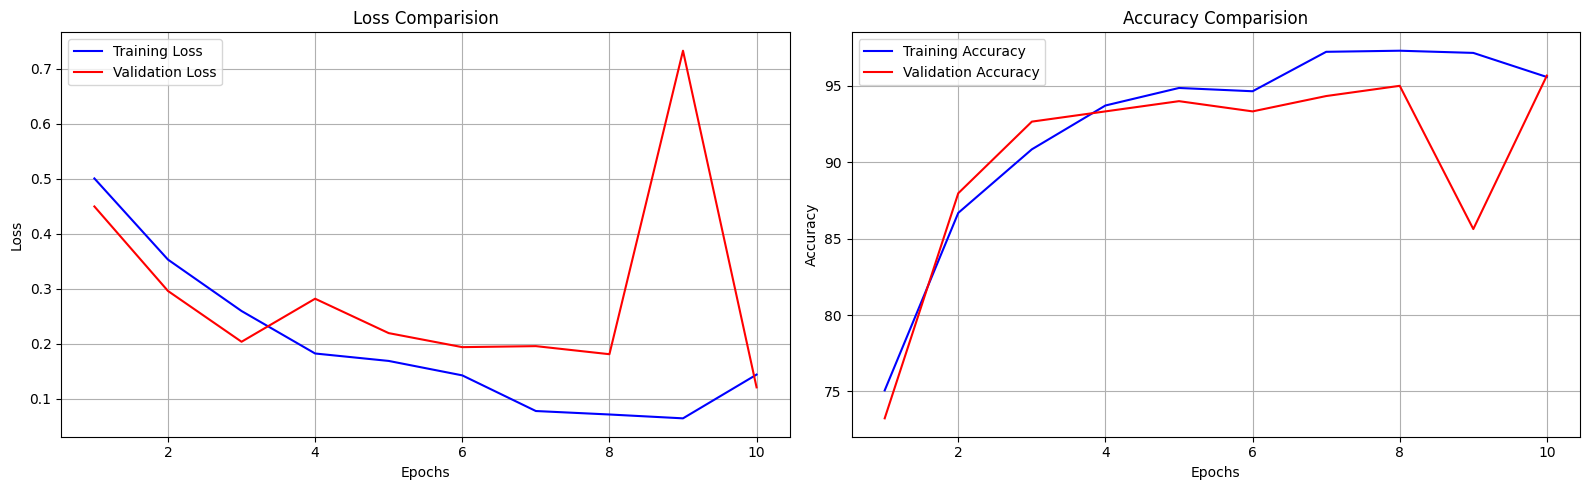

In [ ]:
def plot_roc_curve(y_true, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc = roc_auc_score(y_true, y_pred_proba)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

train_loss, train_acc, val_loss, val_acc = train_and_eval(model, train, val, criterion, optimiser, 10)

### Test metrics and ROC curve

Test Loss: 0.1527
Test Accuracy: 94.33%
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       205
           1       0.90      0.93      0.91        95

    accuracy                           0.94       300
   macro avg       0.93      0.94      0.94       300
weighted avg       0.94      0.94      0.94       300



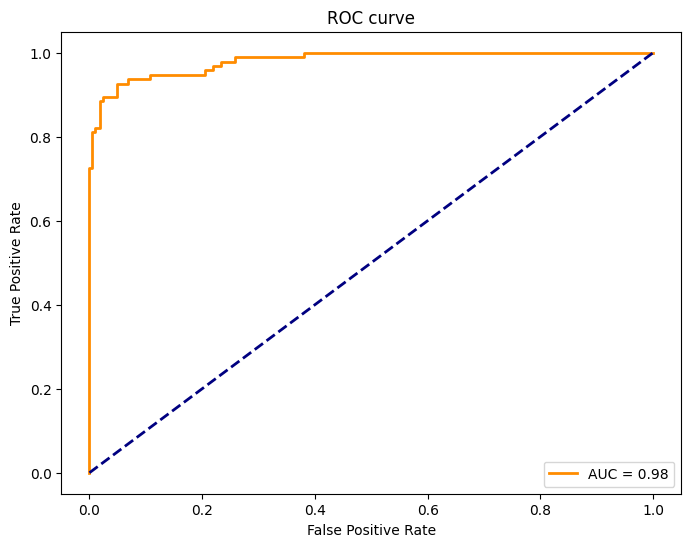

In [ ]:
y_true, y_pred, y_pred_proba = test_model(model, test, criterion)
plot_roc_curve(y_true, y_pred_proba)

In [ ]:
torch.save(model, 'C:/Users/alici/OneDrive - Swansea University/Dissertation/WWFRCNN/model/CNNmodel.pth')

In [ ]:
torch.save(model.state_dict(), 'C:/Users/alici/OneDrive - Swansea University/Dissertation/WWFRCNN/model/CNNmodelWeights.pth')